In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
# import quantstats as qs
# import pycountry
# from statsmodels.tsa.base.datetools import dates_from_str
from pandas import DataFrame, Series, pivot
import pandas as pd
# import modin.pandas as pd
# import datatable as dt

import matplotlib.pyplot as plt
import seaborn as sb

from collections import defaultdict, Counter

In [4]:
import sys
sys.path.append("../")
import funcs

In [4]:
# files = {'cpi': 'data/raw/cpi_all_countries.parquet',
#          'ism_manufacturing': 'data/raw/ism_manufacturing_all_countries.parquet',
#          'ism_non_manufacturing': 'data/raw/ism_non_manufacturing_all_countries.parquet',
#          'etfprices': "data/raw/etfs.csv"}

files = {'cpi': 'data/raw/202309_turnleaf_live_backtest_all_countries_forecasts_ref_date_cpi.parquet',
         'ism_manufacturing': 'data/raw/202311_turnleaf_live_backtest_all_countries_forecasts_ref_date_ism_manufacturing.parquet',
         'ism_non_manufacturing': 'data/raw/202311_turnleaf_live_backtest_all_countries_forecasts_ism_non_manufacturing.parquet',
         'etfprices': "data/raw/etfs.csv"}

country_code_map = {
    'Argentina': 'ARG',
    'Australia': 'AUS',
    'Brazil': 'BRL',
    'Canada': 'CAN',
    'Chile' : 'CHL',
    'China': 'CHI',
    'Colombia': 'COL',
    'Czech Republic': 'CZE',
    'Eurozone': 'EUR',
    'France' : 'FRA',
    'Germany': 'GER',
    'Hungary': 'HUN',
    
    'India': 'IND',
    'Indonesia': 'IDN',
    'Israel' : 'ISR',
    'Italy' : 'ITA',
    'Japan' : 'JPN',
    'Mexico': 'MEX',
    'Netherlands': 'NED',
    'Peru': 'PER',
    'Poland':'POL',
    'Romania': 'ROU',
    'South Africa': 'RSA', # Republic of South Africa
    'South Korea': 'KOR',
    'Spain': 'ESP',
    'Sweden': 'SWE',
    'Switzerland': 'SUI',
    'Thailand': 'THA',
    'Turkey': 'TUR',
    'United Kingdom': 'GBR',
    'United States': "USA"
}

# ETF Data - Load & Prep data set

In [6]:
etfs = pd.read_csv("data/raw/etfs.csv")
# etfs['mid'] = (etfs['high'] + etfs['low']) * .5
etfs = etfs[['sym', 'date', 'open', 'high', 'low', 'mid', 'close', 'volume', 'adjusted']]
etfs.columns = ['ticker', 'date', 'open', 'high', 'low', 'mid', 'close', 'volume', 'adjusted']

etfs['date'] = etfs['date'].apply(lambda x: pd.to_datetime(x).date())
etfs.to_parquet("data/processed/etfs.pq")
etfs.head()

# Construct total return time series per ETF
dfcloses = etfs.pivot(columns='ticker', values='adjusted')
df_total_returns = dfcloses.pct_change().dropna().apply(lambda x: 100*np.cumprod(1 + x))
df_total_returns.to_parquet("data/processed/total_returns.pq")

print("DONE")

In [ ]:
dfetfref = pd.read_csv("data/syms.csv")
dfetfref.drop("Unnamed: 0", axis=1, inplace=True) # remove unnamed index column from data
dfetfref['AssetClass'] = dfetfref['Group'].apply(lambda x: x.split()[0])
dfetfref.columns = ['ticker', 'name', 'launchdate', 'group', 'subgroup', 'style', 'maturity', 'duration', 'assetclass']
dfetfref.set_index('ticker', inplace=True)
dfetfref['assetclass'] = pd.Categorical(dfetfref['assetclass'].values, 
                                        categories=['Debt', 'Equity', 'Commodity'], 
                                        ordered=True)

# dfetfref.to_feather("data/processed/etfref.fthr")
dfetfref.to_parquet("data/processed/etfref.pq")
dfetfref.to_csv("data/processed/etfref.csv")

print("DONE")

In [ ]:
dfetfref

# CPI & ISM Data Counts  
How much data exists in each data set? 

In [5]:
dfcpi = pd.read_parquet(files['cpi'])
dfism_man = pd.read_parquet(files['ism_manufacturing'])
dfism_nonman = pd.read_parquet(files['ism_non_manufacturing'])

rows = [dfcpi.shape[0], dfism_man.shape[0], dfism_nonman.shape[0]]
cols = [dfcpi.shape[1], dfism_man.shape[1], dfism_nonman.shape[1]]
labels = ['CPI', 'ISM Manufacturing', "ISM Non-Manufacturing"]

pd.DataFrame(data={'Rows': rows, 'Columns': cols}, index=labels)

,Rows,Columns
CPI,132,4160
ISM Manufacturing,132,64
ISM Non-Manufacturing,133,63


In [6]:
dfism_nonman.to_clipboard()

## Simplify col names 

In [8]:
# removed non US countries b/c new countries added with data extension
dfcpi = dfcpi[[c for c in dfcpi.columns if c.startswith("United States")]] 
dfcpi = funcs.replace_country_names(dfcpi)
dfcpi = funcs.simplify_cols(dfcpi)
dfcpi = funcs.filter_cols(dfcpi, "usa")
dfcpi.reset_index(inplace=True)
dfcpi['pubdate'] = dfcpi['usa.cpi.yoy.nsa.pubdate'].apply(funcs.adj_date)
dfcpi['refdate'] = dfcpi['usa.cpi.yoy.nsa.refdate']
dfcpi['index'] = dfcpi['refdate'].copy()
# dfcpi['index'] = dfcpi['pubdate'].copy()
# dfcpi['adjpubdate'] = dfcpi['usa.cpi.yoy.nsa.pubdate'].apply(funcs.adj_date)
dfcpi = dfcpi.set_index('index')

In [9]:
# dfism_man = pd.read_parquet("data/processed/ism_man.pq")
dfism_man = funcs.replace_country_names(dfism_man)
dfism_man = funcs.simplify_cols(dfism_man, use_copy=False)
dfism_man = funcs.filter_cols(dfism_man, "usa")
dfism_man.reset_index(inplace=True)
dfism_man['pubdate'] = dfism_man['usa.ism.man.pubdate'].apply(funcs.adj_date)
dfism_man['refdate'] = dfism_man['usa.ism.man.refdate'].copy()
dfism_man['index'] = dfism_man['refdate'].copy()
# dfism_man['index'] = dfism_man['pubdate'].copy()
dfism_man = dfism_man.set_index('index')

In [11]:
dfism_man[['usa.ism.man.pubdate', 'usa.ism.man.refdate']]

,usa.ism.man.pubdate,usa.ism.man.refdate
index,,
2013-01-31,2013-02-01,2013-01-31
2013-02-28,2013-03-01,2013-02-28
2013-03-31,2013-04-01,2013-03-31
2013-04-30,2013-05-01,2013-04-30
2013-05-31,2013-06-03,2013-05-31
...,...,...
2023-08-31,2023-09-05,2023-08-31
2023-09-30,2023-10-03,2023-09-30
2023-10-31,2023-11-06,2023-10-31


In [12]:
dfism_nonman = pd.read_parquet(files['ism_non_manufacturing'])
dfism_nonman = funcs.replace_country_names(dfism_nonman)
dfism_nonman = funcs.simplify_cols(dfism_nonman)
dfism_nonman = funcs.filter_cols(dfism_nonman, "usa")
dfism_nonman.reset_index(inplace=True)
dfism_nonman['pubdate'] = dfism_nonman['index'].apply(pd.to_datetime)
dfism_nonman['refdate'] = dfism_nonman["usa.ism.nonman.refdate"].copy()
dfism_nonman['index'] = dfism_nonman["refdate"].copy()
# dfism_nonman['refdate'] = dfism_nonman['index'].copy()
# dfism_nonman['pubdate'] = dfism_nonman['United States ISM Non Manufacturing Index SA Forecast Date']

dfism_nonman.set_index('index', inplace=True)

# dfism_nonman.head()

In [15]:
dfcpi['refmonthyear'] = dfcpi['refdate'].apply(lambda x: x.strftime("%b.%Y").upper())
dfism_man['refmonthyear'] = dfism_man['refdate'].apply(lambda x: x.strftime("%b.%Y").upper())
dfism_nonman['refmonthyear'] = dfism_nonman['refdate'].apply(lambda x: x.strftime("%b.%Y").upper())

In [19]:
dfism_nonman.reset_index().groupby('refmonthyear').first()

,index,usa.tlbt.ism.nonman.1m,usa.tlbt.ism.nonman.2m,usa.tlbt.ism.nonman.3m,usa.tlbt.ism.nonman.4m,usa.tlbt.ism.nonman.5m,usa.tlbt.ism.nonman.6m,usa.tlbt.ism.nonman.7m,usa.tlbt.ism.nonman.8m,usa.tlbt.ism.nonman.9m,...,usa.tlbt.cons.ism.nonman.date.5m,usa.tlbt.cons.ism.nonman.date.6m,usa.tlbt.cons.ism.nonman.date.7m,usa.tlbt.cons.ism.nonman.date.8m,usa.tlbt.cons.ism.nonman.date.9m,usa.tlbt.cons.ism.nonman.date.10m,usa.tlbt.cons.ism.nonman.date.11m,usa.tlbt.cons.ism.nonman.date.12m,pubdate,refdate
refmonthyear,,,,,,,,,,,,,,,,,,,,,
APR.2013,2013-04-30,54.312,54.721,55.480,55.781,56.051,55.708,55.503,56.109,55.820,...,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2013-05-01,2013-04-30
APR.2014,2014-04-30,55.685,55.142,54.887,56.052,55.669,55.740,55.767,56.074,55.848,...,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2014-05-01,2014-04-30
APR.2015,2015-04-30,55.481,55.614,55.904,56.489,57.254,56.667,56.211,57.036,55.496,...,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2015-05-01,2015-04-30
APR.2016,2016-04-30,55.527,56.218,55.387,54.866,54.377,54.600,54.190,53.767,53.737,...,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2016-05-02,2016-04-30
APR.2017,2017-04-30,58.449,58.670,58.602,58.056,57.882,58.119,57.886,57.595,58.378,...,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2017-05-01,2017-04-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEP.2019,2019-09-30,54.034,54.344,54.885,55.332,56.089,56.613,56.313,55.725,56.311,...,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2019-10-01,2019-09-30
SEP.2020,2020-09-30,57.637,58.452,57.244,56.073,56.851,57.579,56.648,56.383,56.846,...,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2020-10-01,2020-09-30
SEP.2021,2021-09-30,61.063,60.160,59.286,59.524,58.761,57.192,56.788,56.278,55.040,...,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2021-10-05,2021-09-30


In [41]:
# write CPI / ISM data frames to disk
dfcpi.to_parquet("data/processed/cpi_all.pq")
dfism_man.to_parquet("data/processed/ism_man.pq")
dfism_nonman.to_parquet("data/processed/ism_nonman.pq")

# Load ISM data

## Create compact cols for ISM manufacturing data

# ISM Data Description

# Description of CPI data series values - United States
#### NSA YoY, MoM fields  
NSA YoY Forecast Date  
NSA Yoy Reference Date  
NSA YoY Live   
NSA YoY Realised  
NSA YoY 1M, 2M, 3M, 4M, 5M, 6M, 7M, 8M, 9M, 10M, 11M, 12M  
  
NSA MoM Forecast Date  
NSA MoM Reference Date  
NSA MoM Live  
NSA MoM Realised  
NSA MoM 1M, 2M, 3M, 4M, 5M, 6M, 7M, 8M, 9M, 10M, 11M, 12M   

#### Turnleaf Forecast Fields  
Backtest Forecast YoY 1M - 12M  
Backtest Forecast YoY Prediction Horizon for 1M - 12M  
Consensus Backtest Forecast YoY 1M - 12M  
Consensus Backtest Forecast YoY Prediction Horizon for 1M - 12M  

Backtest Forecast MoM 1M - 12M  
Backtest Forecast MoM Prediction Horizon for 1M - 12M  
Consensus Backtest Forecast MoM 1M - 12M  
Consensus Backtest Forecast MoM Prediction Horizon for 1M - 12M  


In [35]:
colsus = [c for c in dfcpi.columns if re.match('United States*', c)]
# colsus.extend(['United States CPI YoY NSA Forecast Date',
#                'United States CPI YoY NSA Reference Date'])
colsustl = [c for c in colsus if ('Turnleaf' in c or 'Date' in c)]

# remove turnleaf cols from US cols
colsusextl = [c for c in colsus if ('Turnleaf' not in c or 'Date' in c)]

In [36]:
dfcpi[colsus].to_feather("data/cpi_us.fthr")

In [87]:
dfcpius = dfcpi[colsusextl]
dfcpiustl = dfcpi[colsustl]

In [106]:
print(dfcpiustl.shape)
print(dfcpius.shape)
print(dfcpi[colsus].shape)

(71, 100)
(71, 32)
(71, 128)


In [89]:
colsnsa = [c for c in colsustl if 'NSA' in c]
len(colsustl)

100

## Examine CPI fields for stationarity  
If source value and 1M forecast values are stationary, assumption is that subsequent forecasts will also exhibit stationary properties

In [95]:
# Inspection 
colsyoy = [
    'United States CPI YoY NSA Forecast Date',
    'United States CPI YoY NSA Reference Date',    
    'United States Turnleaf Backtest Forecast CPI YoY NSA Prediction Horizon for 6M',
    'United States Turnleaf Consensus Backtest Forecast CPI YoY NSA Prediction Horizon for 6M',
    'United States Turnleaf Backtest Forecast CPI YoY NSA 6M',
    'United States Turnleaf Consensus Backtest Forecast CPI YoY NSA 6M',
    'United States CPI YoY NSA Realised 6M']

colsmom = [
    'United States CPI MoM NSA Forecast Date',
    'United States CPI MoM NSA Reference Date',
    'United States Turnleaf Backtest Forecast CPI MoM NSA Prediction Horizon for 6M',
    'United States Turnleaf Consensus Backtest Forecast CPI MoM NSA Prediction Horizon for 6M'
    'United States Turnleaf Backtest Forecast CPI MoM NSA 6M',
    'United States Turnleaf Consensus Backtest Forecast CPI MoM NSA 6M',
    'United States CPI MoM NSA Realised 6M']

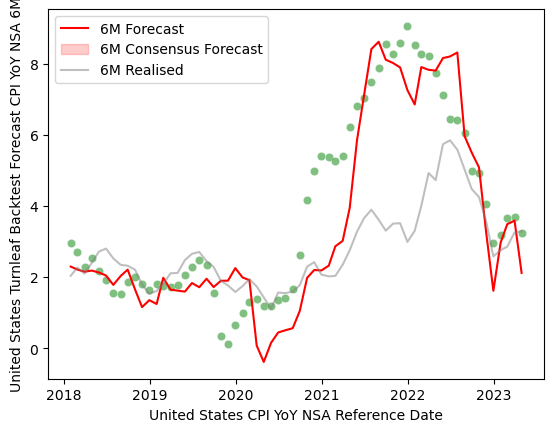

In [102]:
sb.lineplot(data = dfcpi[colsyoy].dropna().reset_index(), 
            color='red',
            x=f'United States CPI YoY NSA Reference Date',
            y=f'United States Turnleaf Backtest Forecast CPI YoY NSA 6M');

sb.lineplot(data = dfcpi[colsyoy].dropna().reset_index(),
            color='gray', alpha=.5,
            x=f'United States CPI YoY NSA Reference Date',
            y=f'United States Turnleaf Consensus Backtest Forecast CPI YoY NSA 6M');

sb.scatterplot(data = dfcpi[colsyoy].dropna().reset_index(),
               color='green', alpha=.5,
               x=f'United States CPI YoY NSA Reference Date',
               y=f'United States CPI YoY NSA Realised 6M');

plt.legend(labels=[f'6M Forecast', f'6M Consensus Forecast', f'6M Realised']);

In [92]:
for c in colsus:
    if 'NSA 6M' in c:
        print(c)

United States Turnleaf Backtest Forecast CPI YoY NSA 6M
United States Turnleaf Consensus Backtest Forecast CPI YoY NSA 6M
United States Turnleaf Backtest Forecast CPI MoM NSA 6M
United States Turnleaf Consensus Backtest Forecast CPI MoM NSA 6M


In [112]:
funcs.adf_test(dfcpi['United States CPI YoY NSA Realised'].diff().dropna())

Results of Dickey-Fuller Test:
TStat                   -3.291481
p-value                  0.015264
#Lags Used              11.000000
NObs                    57.000000
Critical Value (1%)     -3.550670
Critical Value (5%)     -2.913766
Critical Value (10%)    -2.594624
dtype: float64


TStat                   -3.291481
p-value                  0.015264
#Lags Used              11.000000
NObs                    57.000000
Critical Value (1%)     -3.550670
Critical Value (5%)     -2.913766
Critical Value (10%)    -2.594624
dtype: float64

In [17]:
etfs['date'].values[0:3]

array([datetime.date(2008, 11, 11), datetime.date(2008, 11, 12),
       datetime.date(2008, 11, 13)], dtype=object)